In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from svetlanna.phase_retrieval_problem import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna import LinearOpticalSetup
from svetlanna.units import ureg

# Задача восстановления фазы

Рассмотрим оптическую систему, которая состоит из источника света, генерирующего пучок Гаусса, собирающей линзы и экрана, расположенного в задней фокальной плоскости линзы.

Для такой системы численно решим прямую задачу дифракции и найден распределение интенсивности на поверхности экрана. После этого решим задачу восстановления фазы с использованием модуля `svetlanna.phase_retrieval` : восстановим функцию пропускания собирающей линзы, зная распределения интенсивности в плоскости экрана и в плоскости перед линзой.

## Создание расчетной сетки с использованием класса `SimulationParameters`

In [18]:
# размер экрана
lx = 10 * ureg.mm
ly = 10 * ureg.mm

# количество точек в расчетной сетке
Nx = 1024
Ny = 1024

# длина волны света
wavelength = 1064 * ureg.nm

# фокальное расстояние линзы
focal = 10 * ureg.cm

# радиус линзы
r = 1 * ureg.cm
# расстояние между линзой и экраном
distance = focal * 1.

# радиус перетяжки пучка Гаусса
w0 = 1 * ureg.mm

sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [19]:
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Решение прямой задачи дифракции

In [20]:
incident_wavefront = Wavefront.gaussian_beam(
    simulation_parameters=sim_params,
    waist_radius=w0,
    distance=distance
)

source_intensity = incident_wavefront.intensity

lens = elements.ThinLens(
    simulation_parameters=sim_params,
    focal_length=focal,
    radius=r
)

field_after_lens = lens.forward(incident_wavefront=incident_wavefront)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=distance,
    method="AS"
)

output_field = free_space.forward(incident_wavefront=field_after_lens)

target_intensity = output_field.intensity

Создадим модель оптической системы, через которую проходит пучок 

In [21]:
optical_setup = LinearOpticalSetup([free_space])

## Решение задачи восстановления фазы

Для решения задачи восстановления фазы необходимо определить распределение интенсивности падающего на систему излучения `source_intensity`, целевое распределение интенсивности `target_intensity` и метод оптимизации в функции `phase_retrieval.retrieve_phase`. Дополнительно можно настроить параметры алгоритма используя параметр `options`, который представляет собой словарь. 

In [22]:
result_gs = phase_retrieval.retrieve_phase(
    source_intensity=source_intensity,
    optical_setup=optical_setup,
    target_intensity=target_intensity,
    method='GS',
    options= {
        'tol': 1e-16,
        'maxiter': 12,
        'disp': False
    }
)

In [23]:
phase_distribution_gs = result_gs.solution

niter_gs = result_gs.number_of_iterations

error_mass_gs = result_gs.cost_func_evolution

## Решение прямой задачи дифракции с восстановленным распределением фазы

In [24]:
layer = elements.DiffractiveLayer(
    simulation_parameters=sim_params,
    mask=phase_distribution_gs
)

field_after_layer = layer.forward(incident_wavefront=incident_wavefront)
output_field_retrieved = free_space.forward(incident_wavefront=field_after_layer)

target_intensity_retrieved = output_field_retrieved.intensity

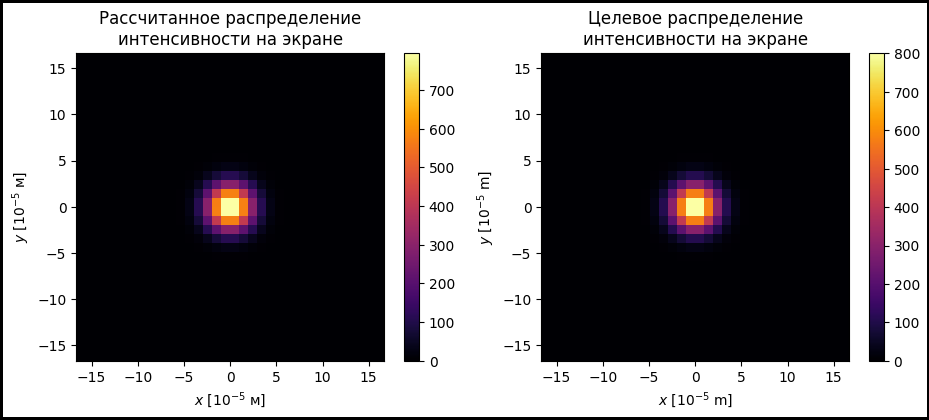

In [25]:
fig, ax = plt.subplots(
    1, 2, figsize=(11, 4), edgecolor='black', linewidth=3, frameon=True
)

scale_factor = 1e5
x_grid_scaled = x_grid * scale_factor
y_grid_scaled = y_grid * scale_factor

im1 = ax[0].pcolormesh(x_grid_scaled, y_grid_scaled, target_intensity_retrieved, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title('Рассчитанное распределение\nинтенсивности на экране')
ax[0].set_xlabel('$x$ [$10^{-5}$ м]')
ax[0].set_ylabel('$y$ [$10^{-5}$ м]')
ax[0].set_xlim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
ax[0].set_ylim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(x_grid_scaled, y_grid_scaled, target_intensity, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Целевое распределение\nинтенсивности на экране')
ax[1].set_xlabel('$x$ [$10^{-5}$ m]')
ax[1].set_ylabel('$y$ [$10^{-5}$ m]')
ax[1].set_xlim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
ax[1].set_ylim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
fig.colorbar(im2, ax=ax[1])

plt.show()

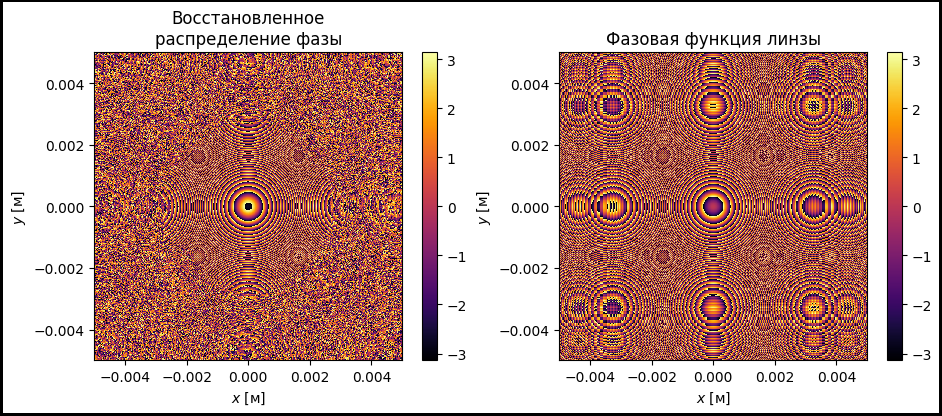

In [26]:
fig, ax = plt.subplots(
    1, 2, figsize=(11, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(x_grid, y_grid, phase_distribution_gs, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title('Восстановленное\nраспределение фазы')
ax[0].set_xlabel('$x$ [м]')
ax[0].set_ylabel('$y$ [м]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(x_grid, y_grid, torch.real(torch.log(lens.transmission_function) / 1j), cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Фазовая функция линзы')
ax[1].set_xlabel('$x$ [м]')
ax[1].set_ylabel('$y$ [м]')
fig.colorbar(im2)

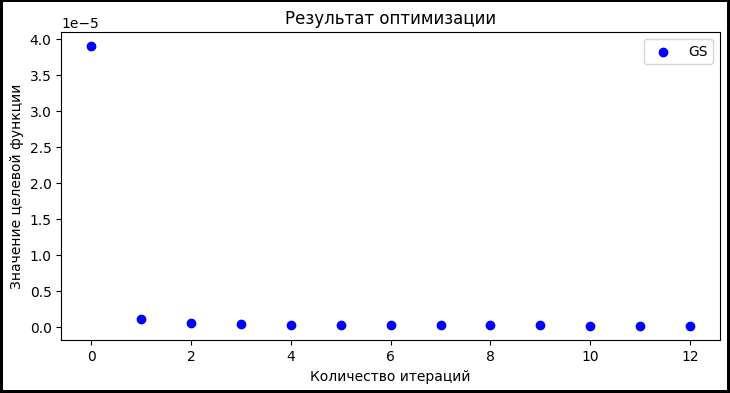

In [27]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)

ax.set_title('Результат оптимизации')
ax.set_xlabel('Количество итераций')
ax.set_ylabel('Значение целевой функции')

n_gs = np.arange(0, niter_gs+1)
ax.scatter(n_gs, error_mass_gs, label='GS', color='blue')

ax.legend()